In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer

In [14]:
class MyDenseLayer(Layer):

    def __init__(self, kernel_initilizer=tf.keras.initializers.Identity(), num_outputs=1, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initilizer)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._b = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
#         self._c = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._d = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._e = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._f = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._g = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._h = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._i = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._j = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
        
#         self._k = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._l = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, x):
        return self._b*x + (1 - self._b)*tf.math.sign(x)
        #return self._b*x + self._c * (x**2) + self._d * (x**3) + self._e * (x**4) + self._f * (x**5) + self._g * (x**6) + self._h * (x**7) + self._i * (x**8) + self._j * (x**9) + self._k * (x**10) + self._l * (x**11)
        #return self._c*tf.math.sign(x)
        #return tf.linalg.matmul(tf.nn.relu(x), self._b) - tf.linalg.matmul(tf.nn.relu(-x), self._c) + self._d

In [18]:
#Define the discriminator
opt = tf.keras.optimizers.Adam(learning_rate=1)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)
hidden_layer_6 = Dense(50, activation='relu')(hidden_layer_5)
outputs = Dense(1, activation='sigmoid')(hidden_layer_6)
Discriminator = Model(inputs=inputs, outputs=outputs)
Discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#Define the mapping function:
inputsM = Input((1, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
#hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
#hidden_layer_3M = MyDenseLayer()(hidden_layer_2M)
#hidden_layer_4M = MyDenseLayer()(hidden_layer_3M)
#hidden_layer_5M = MyDenseLayer()(hidden_layer_4M)
#hidden_layer_6M = MyDenseLayer()(hidden_layer_5M)
hidden_layer_7M = Dense(1, activation='linear', kernel_initializer=initializer)(hidden_layer_1M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_1M)

#Define the generator
inputsG = Input((2, ))
concatenate_layerG = Concatenate()([MappingFunc(inputsG[:,1:2]),inputsG[:,0:1]])
outputG = concatenate_layerG[:, 0]*concatenate_layerG[:, 1]
Generator = Model(inputs=inputsG, outputs=outputG)

#Define the full GAN for training
inputsGAN = Input((2, ))
GAN = Model(inputs=inputsGAN,outputs=Discriminator(Generator(inputsGAN)))
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
# generate n real samples with class labels
def generate_real_samples(n):
    rng = np.random.default_rng()
    x = rng.normal(0,1,n)
    y = np.ones((n, 1))
    c = np.random.uniform(-1.5,1.5,n) #[-1.5]*(n//4) + [1.5]*(n//4) + [0.5]*(n//4) + [-0.5]*(n//4)  # 
    X = np.c_[x,c]
    rng.shuffle(X)
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(real_samples,generator, n):
    # predict outputs
    X = np.c_[Generator.predict(real_samples),real_samples[:,1]]
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [25]:
m = 2000
n_batch = m
n_epochs = 5*m
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(x_real, Generator, half_batch)
    Discriminator.train_on_batch(x_real[:,0], y_real)
    Discriminator.train_on_batch(x_fake[:,0], y_fake)
    Discriminator.trainable = False
    # update the generator via the discriminator's error
    loss = GAN.train_on_batch(x_real, np.ones(len(x_real)), return_dict=True)
    Discriminator.trainable = True
    #Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if(i%m == 0):
        print(i,MappingFunc.predict([[1]]))
        print(loss)

0 [[1.]]
{'loss': 0.41416409611701965, 'accuracy': 1.0}
2000 [[1.]]
{'loss': 0.41416412591934204, 'accuracy': 1.0}
4000 [[1.]]
{'loss': 0.41416412591934204, 'accuracy': 1.0}
6000 [[1.]]
{'loss': 0.41416412591934204, 'accuracy': 1.0}
8000 [[1.]]
{'loss': 0.41416412591934204, 'accuracy': 1.0}


In [13]:
MappingFunc.predict([[0.5]])

array([[0.8357174]], dtype=float32)

In [169]:
MappingFunc.predict([[-0.5]])

array([[-0.8247875]], dtype=float32)

In [170]:
MappingFunc.predict([[1.5]])

array([[0.6960026]], dtype=float32)

In [171]:
MappingFunc.predict([[-1.5]])

array([[-0.68608916]], dtype=float32)

In [21]:
c_i = np.random.uniform(-1.5,1.5,m)
c_f = []


for j in range(m):
    preds = MappingFunc.predict([[c_i[j]]])
    c_f.append(preds[0,0])

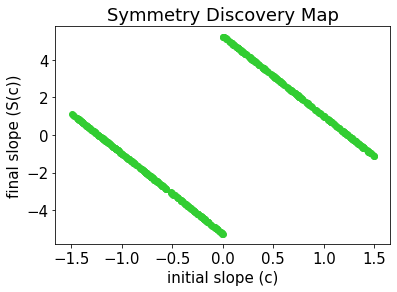

In [23]:
plt.rc('font', size=15)
plt.title("Symmetry Discovery Map")
plt.scatter(c_i, c_f, color='limegreen')
plt.xlabel("initial slope (c)")
plt.ylabel("final slope (S(c))")
plt.savefig("Augmentation.pdf", bbox_inches='tight')
plt.show()

In [24]:
print(f'c_i = {c_i}')
print(f'c_f = {c_f}')

c_i = [ 1.14955439 -0.41081221  0.28901427  1.44230196 -0.87387236 -0.88565216
  0.73732508  0.71583408 -1.18337399  1.12641503 -0.4414858  -0.88147022
  0.60641745 -0.05976692 -0.33088347  1.2786814   0.8810508  -0.24377406
 -0.29800486  0.30329809 -1.08992099  1.39685263  1.28023089  1.07324287
 -0.51817483 -0.17246541 -0.79430023 -0.88430067 -1.33531398 -0.93774571
  0.76366824  0.51767166  0.59381051  1.22323235 -1.22450029 -0.61869995
 -0.06872249  0.67992119 -1.33650849 -0.86072736  0.09145148 -0.44612151
  0.18318965 -0.64795372 -1.07001992 -0.61389693  1.33838078 -0.04035718
 -0.60298012  1.27284397  0.9448372  -0.93964537  1.31600571 -1.11207336
  0.40728794  0.82262016 -1.26025581 -0.19879757  1.27620292 -0.5582429
 -0.70925626 -0.60399834 -1.18426787  0.00778511 -0.4986901   0.5623829
  0.39756406 -0.94676262  1.38508183 -0.00355875  0.85813929  1.19900637
 -1.03331863  0.75594303 -0.17899348 -0.78163856 -0.29515649 -0.18605135
 -0.00917471 -1.35583214  1.3145551   0.8325553

5.283185307179586